In [32]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict
import pickle
from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import LearningRateMonitor
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt

In [2]:
path = './RML2016.10a_dict.pkl'

In [3]:
def read(path: str) -> Tuple[np.ndarray, Dict]:
    with open(path, "rb") as infile:
        data = pickle.load(infile, encoding="latin")

        description = defaultdict(list)
        # Declare j just to get the linter to stop complaining about the lamba below
        j = None
        snrs, mods = map(
            lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1, 0]
        )
        for mod in mods:
            for snr in snrs:
                description[mod].append(snr)

        return data, description

In [4]:
data, description = read(path)

In [5]:
# list the available modulation types
description.keys()

dict_keys(['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM'])

In [6]:
# categorize the modulation types into digital and anolog
analog_modulations = ["WBFM", "AM-SSB", "AM-DSB"]
digital_modulations = ["BPSK", "QPSK", "8PSK", "QAM16", "CPFSK", "GFSK", "PAM4", "QAM64"]

In [7]:
df = pd.DataFrame(columns=["SNR", "I", "Q", "Modulation"])

for modulation in description.keys():
    if modulation in digital_modulations:
        for snr in description[modulation]:
            mod_snr = data[(modulation, snr)]
            df_section = pd.DataFrame(columns=["SNR", "I", "Q", "Modulation"])
            df_section['SNR'] = np.ones(mod_snr.shape[0]) * snr
            df_section['Modulation'] = mod_snr.shape[0] * [modulation]

            for idx, v in enumerate(mod_snr):
                df_section['I'][idx] = v[0,...]
                df_section['Q'][idx] = v[1,...]
                idx += 1

            df = df.append(df_section, ignore_index=True)
    else:
        print(f"Discarding: {modulation}")

/home/thallessilva/anaconda3/envs/image/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/thallessilva/anaconda3/envs/image/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Discarding: AM-DSB
Discarding: AM-SSB
Discarding: WBFM


In [8]:
# convert the Modulation column into a Target categorical colum
le = preprocessing.LabelEncoder()
df['Target'] = le.fit_transform(df['Modulation'])

In [9]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (160000, 5)


In [10]:
# Split the data into train, val, and test. Make sure the split is stratified across signal-to-noise-ratio (SNR)
X_train, X_test = train_test_split(df, stratify=df["SNR"].values, test_size=0.15)
X_train, X_val = train_test_split(X_train, stratify=X_train["SNR"].values, test_size=0.05)

In [11]:
print(f"Train data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (129200, 5)
Validation data shape: (6800, 5)
Test data shape: (24000, 5)


array([[<AxesSubplot:title={'center':'SNR'}>]], dtype=object)

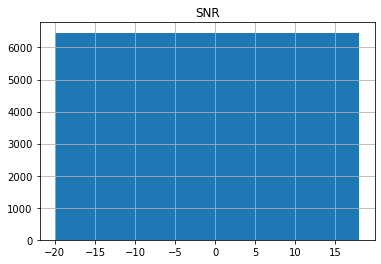

In [12]:
# make sure that train and test have equal observations accross SNR
X_train.hist('SNR', bins=20)

array([[<AxesSubplot:title={'center':'SNR'}>]], dtype=object)

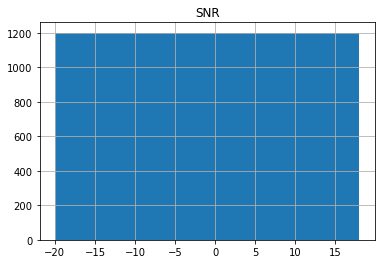

In [13]:
# make sure that train and test have equal observations accross SNR
X_test.hist('SNR', bins=20)

In [14]:
def create_pytorch_dataset(df, target_column="Target"):
    data = np.stack([np.stack(df['I'].values, axis=0), np.stack(df['Q'].values, axis=0)], axis=1)
    data = np.expand_dims(data, axis=1)
    dataset = torch.utils.data.TensorDataset(torch.tensor(data),torch.tensor(df[target_column].values))
    return dataset

In [15]:
train_dataset = create_pytorch_dataset(X_train)
val_dataset = create_pytorch_dataset(X_val)
test_dataset = create_pytorch_dataset(X_test)

In [16]:
for x, y in train_dataset:
    print(x.shape, y)
    print(x.min(), x.max())
    break

torch.Size([1, 2, 128]) tensor(6)
tensor(-0.0121) tensor(0.0100)


In [17]:
class Classifier(pl.LightningModule):
    def __init__(self, input_samples: int, n_classes: int):
        
        super().__init__()
        self.learning_rate = 0.1
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=(1, 7),
                padding=(0, 3),
                bias=False,
            ),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.BatchNorm2d(64),

            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(1, 7),
                padding=(0, 3),
                bias=True,
            ),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=(2, 7),
                padding=(0, 3),
                bias=True,
            ),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            
            nn.Linear(256 * 1 * input_samples, 256),
            nn.Dropout(0.6),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

    def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), weight_decay=0.0002, lr=self.learning_rate)
        optimizer = torch.optim.SGD(self.parameters(), 
                                    momentum=0.9, lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.trainer.max_epochs)
        return [optimizer], [scheduler]

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.network(x)    

        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.train_accuracy(logits, y))
        return loss
    
    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.train_accuracy.compute())

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.network(x)    
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc_step', self.val_accuracy(logits, y))

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            train_dataset, shuffle=True, batch_size=512
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            val_dataset, shuffle=True, batch_size=1024
        )
        return val_loader

In [18]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=1024
)

In [19]:
epochs = 20

In [20]:
# model
model = Classifier(input_samples=128, n_classes=len(le.classes_))

lr_monitor = LearningRateMonitor(logging_interval='step')

# training
trainer = pl.Trainer(min_epochs=0, max_epochs=epochs, check_val_every_n_epoch=1,
                     val_check_interval=0.25, auto_lr_find=True, callbacks=[lr_monitor])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [21]:
# find the best learning rate
trainer.tune(model)


  | Name           | Type       | Params
----------------------------------------------
0 | train_accuracy | Accuracy   | 0     
1 | val_accuracy   | Accuracy   | 0     
2 | network        | Sequential | 8.9 M 
----------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.637    Total estimated model params size (MB)
/home/thallessilva/anaconda3/envs/image/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"
/home/thallessilva/anaconda3/envs/image/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc_step': 0.12147058546543121, 'val_loss': 2.1177916526794434}
--------------------------------------------------------------------------------


Finding best initial lr: 100%|██████████| 100/100 [02:52<00:00,  1.63s/it]Restoring states from the checkpoint file at /home/thallessilva/Downloads/RML2016.10a/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/thallessilva/Downloads/RML2016.10a/lr_find_temp_model.ckpt
Learning rate set to 0.2754228703338169


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7fcf4ccd6fd0>}

In [22]:
trainer.fit(model)


  | Name           | Type       | Params
----------------------------------------------
0 | train_accuracy | Accuracy   | 0     
1 | val_accuracy   | Accuracy   | 0     
2 | network        | Sequential | 8.9 M 
----------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.637    Total estimated model params size (MB)


Epoch 0:  22%|██▏       | 63/281 [01:43<-1:49:36, -0.35it/s, loss=1.35, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 0:  28%|██▊       | 78/281 [02:00<-1:40:32, -0.17it/s, loss=1.32, v_num=53]

Finding best initial lr: 100%|██████████| 100/100 [04:55<00:00,  2.96s/it]


Epoch 0:  48%|████▊     | 135/281 [03:32<14:22,  5.91s/it, loss=1.17, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 0:  73%|███████▎  | 205/281 [05:23<03:52,  3.05s/it, loss=1.12, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 0:  99%|█████████▊| 277/281 [07:11<00:09,  2.43s/it, loss=1.1, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  23%|██▎       | 64/281 [01:42<-1:49:25, -0.34it/s, loss=1.05, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  48%|████▊     | 134/281 [03:30<14:44,  6.02s/it, loss=1.06, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 1:  73%|███████▎  | 206/281 [05:18<03:43,  2.98s/it, loss=1.04, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 1:  98%|█████████▊| 276/281 [07:06<00:12,  2.41s/it, loss=1.06, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 2:  23%|██▎       | 64/281 [01:41<-1:49:28, -0.34it/s, loss=1.02, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  48%|████▊     | 134/281 [03:31<14:47,  6.04s/it, loss=1.02, v_num=53]   
Validating: 0it 

Epoch 3:  73%|███████▎  | 206/281 [05:18<03:43,  2.98s/it, loss=0.99, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  98%|█████████▊| 276/281 [07:06<00:12,  2.41s/it, loss=0.99, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  23%|██▎       | 64/281 [01:40<-1:49:36, -0.35it/s, loss=0.976, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  48%|████▊     | 134/281 [03:29<14:38,  5.98s/it, loss=0.969, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 4:  73%|███████▎  | 206/281 [05:17<03:42,  2.96s/it, loss=0.965, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 4:  98%|█████████▊| 276/281 [07:04<00:11,  2.40s/it, loss=0.973, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 5:  23%|██▎       | 64/281 [01:42<-1:49:23, -0.34it/s, loss=0.966, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 5:  48%|████▊     | 134/281 [03:30<14:44,  6.02s/it, loss=0.962, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 5:  73%|███████▎  | 206/281 [05:18<03:43,  2.97s/it, loss=0.974, v_num=53]
Validatin

Epoch 6:  73%|███████▎  | 206/281 [05:17<03:42,  2.97s/it, loss=0.94, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  98%|█████████▊| 276/281 [07:05<00:12,  2.40s/it, loss=0.952, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 7:  23%|██▎       | 64/281 [01:41<-1:49:33, -0.35it/s, loss=0.917, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 7:  48%|████▊     | 134/281 [03:28<14:37,  5.97s/it, loss=0.935, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 7:  73%|███████▎  | 206/281 [05:16<03:41,  2.96s/it, loss=0.942, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 7:  98%|█████████▊| 276/281 [07:05<00:12,  2.40s/it, loss=0.951, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 8:  23%|██▎       | 64/281 [01:41<-1:49:31, -0.34it/s, loss=0.927, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 8:  48%|████▊     | 134/281 [03:28<14:36,  5.96s/it, loss=0.929, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 8:  73%|███████▎  | 206/281 [05:15<03:41,  2.95s/it, loss=0.927, v_num=53]
Validatin

Epoch 9:  73%|███████▎  | 206/281 [05:15<03:40,  2.95s/it, loss=0.911, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 9:  98%|█████████▊| 276/281 [07:01<00:11,  2.38s/it, loss=0.919, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 10:  23%|██▎       | 64/281 [01:40<-1:49:36, -0.35it/s, loss=0.916, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 10:  48%|████▊     | 134/281 [03:27<14:31,  5.93s/it, loss=0.915, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 10:  73%|███████▎  | 206/281 [05:15<03:40,  2.94s/it, loss=0.91, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 10:  98%|█████████▊| 276/281 [07:02<00:11,  2.39s/it, loss=0.92, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 11:  23%|██▎       | 64/281 [01:40<-1:49:34, -0.35it/s, loss=0.917, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 11:  48%|████▊     | 134/281 [03:28<14:35,  5.96s/it, loss=0.901, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 11:  73%|███████▎  | 206/281 [05:16<03:41,  2.95s/it, loss=0.904, v_num=53]
Vali

Epoch 12:  73%|███████▎  | 206/281 [05:17<03:42,  2.97s/it, loss=0.901, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 12:  98%|█████████▊| 276/281 [07:04<00:12,  2.40s/it, loss=0.909, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 13:  23%|██▎       | 64/281 [01:40<-1:49:35, -0.35it/s, loss=0.889, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 13:  48%|████▊     | 134/281 [03:27<14:32,  5.94s/it, loss=0.895, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 13:  73%|███████▎  | 206/281 [05:15<03:41,  2.95s/it, loss=0.87, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 13:  98%|█████████▊| 276/281 [07:02<00:11,  2.39s/it, loss=0.89, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 14:  23%|██▎       | 64/281 [01:40<-1:49:35, -0.35it/s, loss=0.881, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 14:  48%|████▊     | 134/281 [03:27<14:32,  5.94s/it, loss=0.872, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 14:  73%|███████▎  | 206/281 [05:14<03:40,  2.94s/it, loss=0.881, v_num=53]


Epoch 15:  73%|███████▎  | 206/281 [05:13<03:39,  2.93s/it, loss=0.868, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 15:  98%|█████████▊| 276/281 [07:00<00:11,  2.37s/it, loss=0.86, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 16:  23%|██▎       | 64/281 [01:40<-1:49:38, -0.35it/s, loss=0.881, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 16:  48%|████▊     | 134/281 [03:28<14:35,  5.95s/it, loss=0.862, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 16:  73%|███████▎  | 206/281 [05:15<03:40,  2.95s/it, loss=0.847, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 16:  98%|█████████▊| 276/281 [07:02<00:11,  2.38s/it, loss=0.867, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 17:  23%|██▎       | 64/281 [01:40<-1:49:35, -0.35it/s, loss=0.866, v_num=53] 
Validating: 0it [00:00, ?it/s]
Epoch 17:  48%|████▊     | 134/281 [03:27<14:31,  5.93s/it, loss=0.86, v_num=53]    
Validating: 0it [00:00, ?it/s]
Epoch 17:  73%|███████▎  | 206/281 [05:13<03:39,  2.93s/it, loss=0.866, v_num=53]
Va

Epoch 18:  73%|███████▎  | 206/281 [05:14<03:40,  2.93s/it, loss=0.854, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 18:  98%|█████████▊| 276/281 [07:00<00:11,  2.38s/it, loss=0.861, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 19:  23%|██▎       | 64/281 [01:42<-1:49:23, -0.34it/s, loss=0.862, v_num=53]  
Validating: 0it [00:00, ?it/s]
Epoch 19:  48%|████▊     | 134/281 [03:29<14:38,  5.97s/it, loss=0.858, v_num=53]   
Validating: 0it [00:00, ?it/s]
Epoch 19:  73%|███████▎  | 206/281 [05:15<03:41,  2.95s/it, loss=0.864, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 19:  98%|█████████▊| 276/281 [07:02<00:11,  2.39s/it, loss=0.864, v_num=53]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████| 281/281 [07:08<00:00,  2.36s/it, loss=0.861, v_num=53]


In [23]:
preds = []
targets = []
model.eval()

for x, y in test_loader:
    logits = model(x)
    preds.extend(torch.argmax(logits, dim=1))
    targets.extend(y)
    
preds = torch.tensor(preds)
targets = torch.tensor(targets)

In [24]:
confmat = ConfusionMatrix(num_classes=8)
cm = confmat(preds, targets)

In [50]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True) ->float:
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    return accuracy

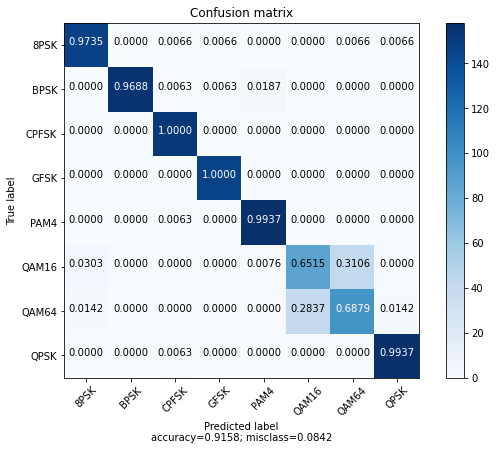

0.9158333333333334

In [51]:
plot_confusion_matrix(cm.numpy(), target_names=le.classes_)

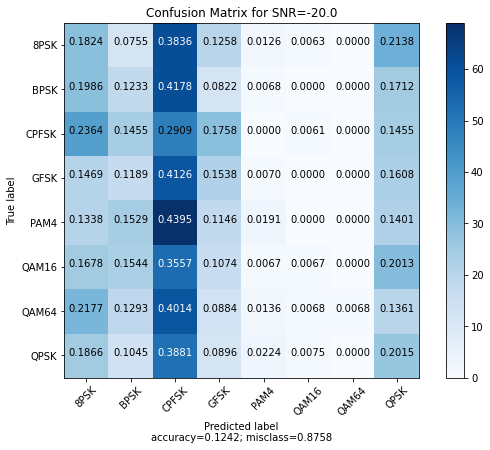

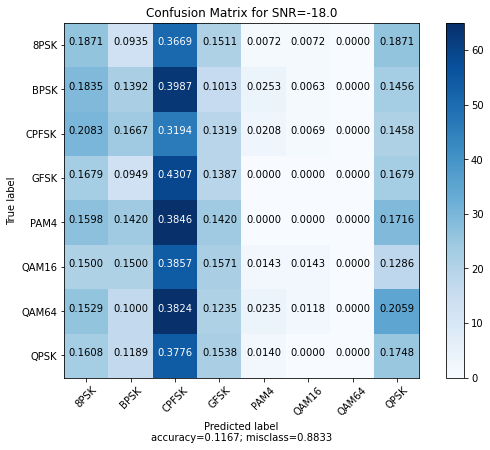

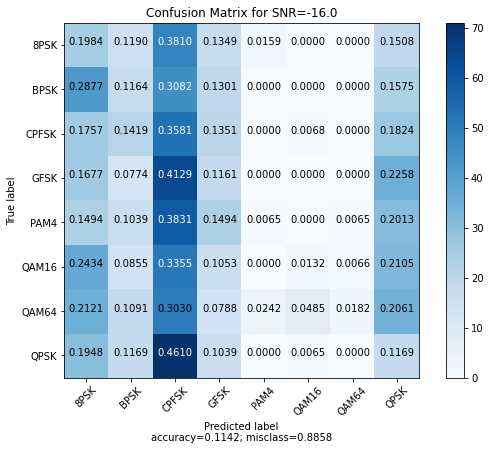

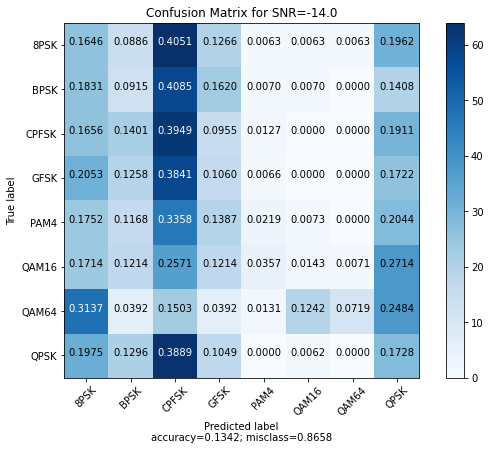

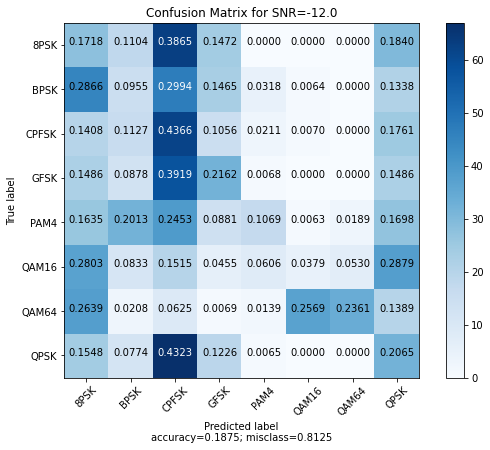

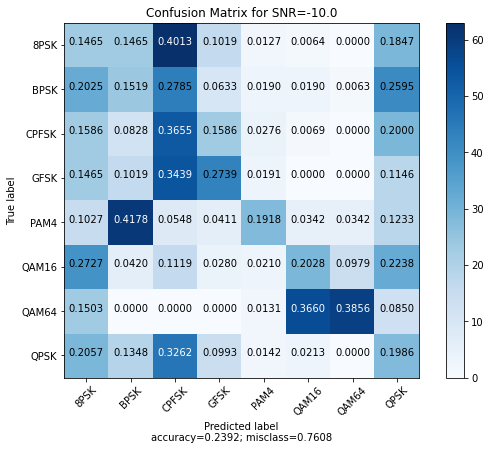

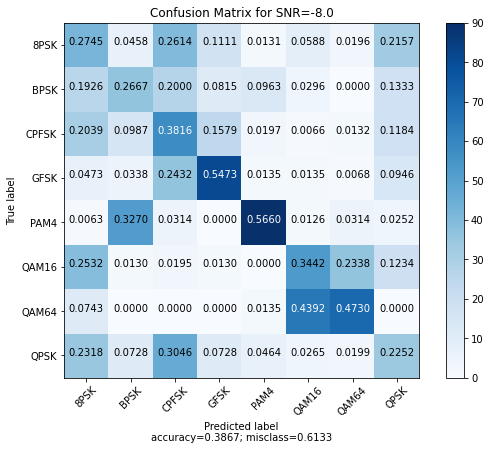

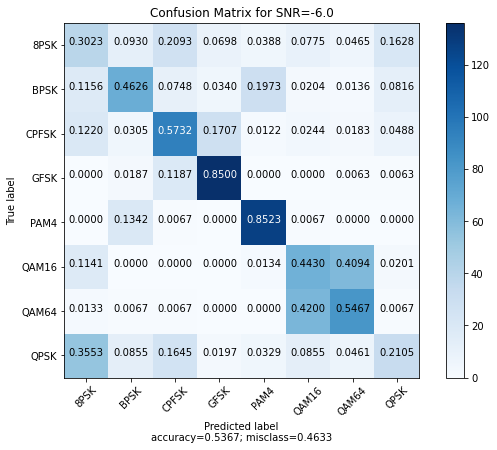

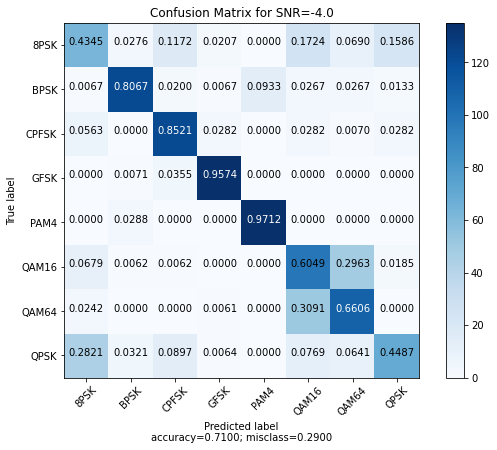

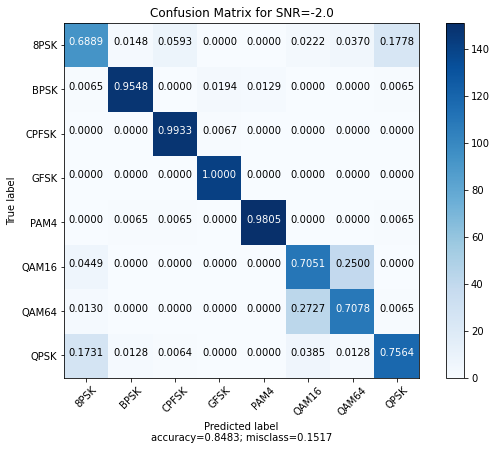

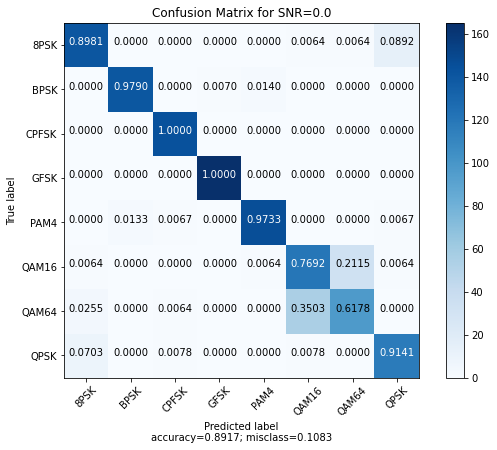

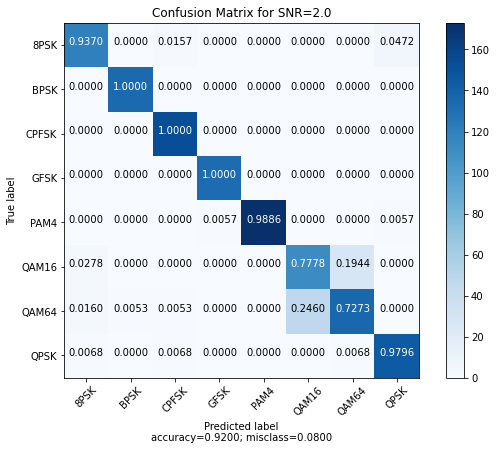

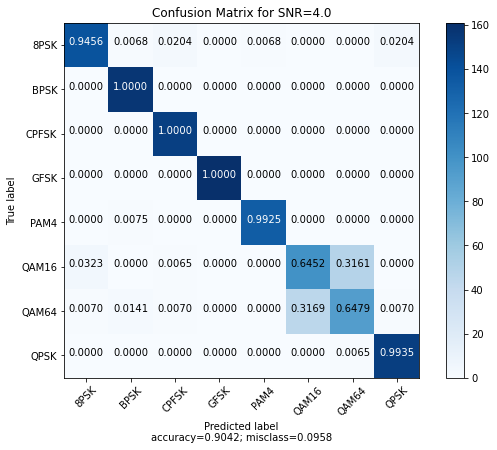

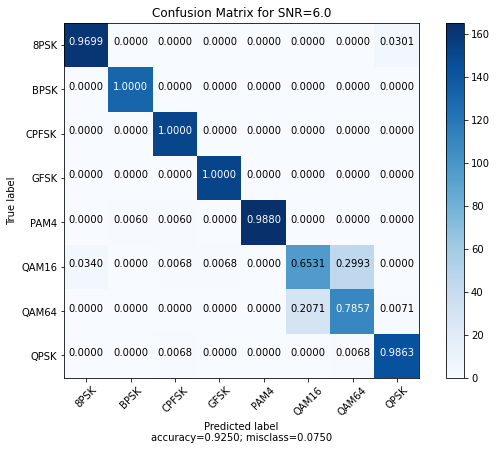

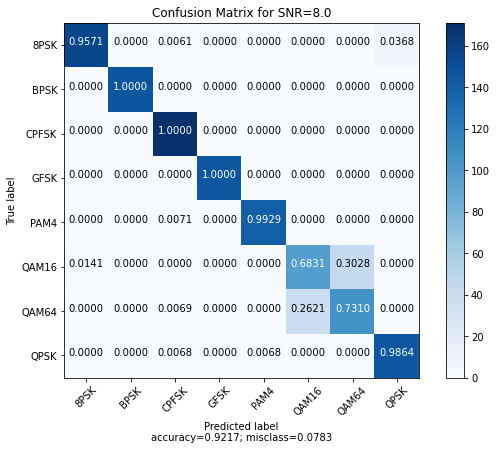

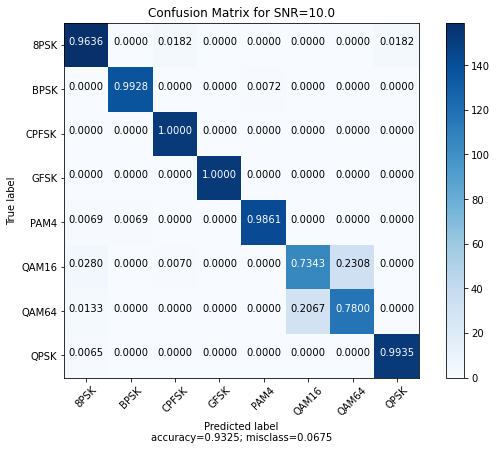

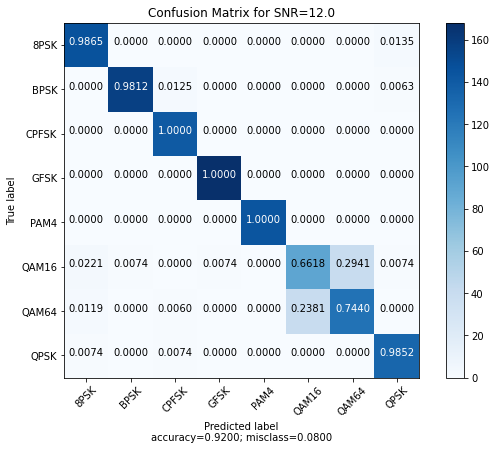

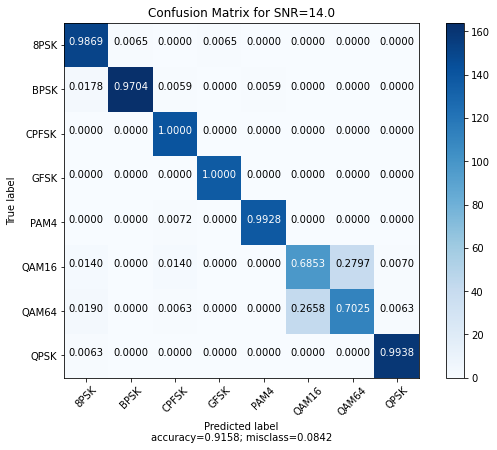

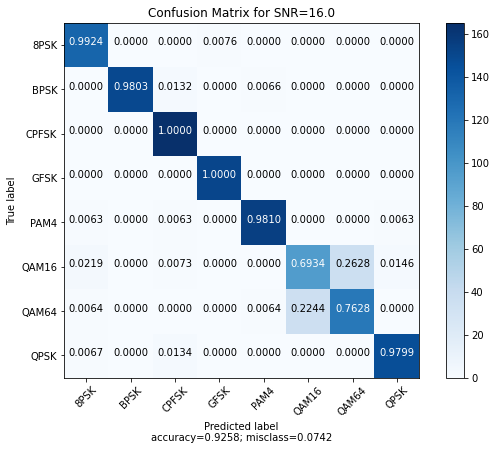

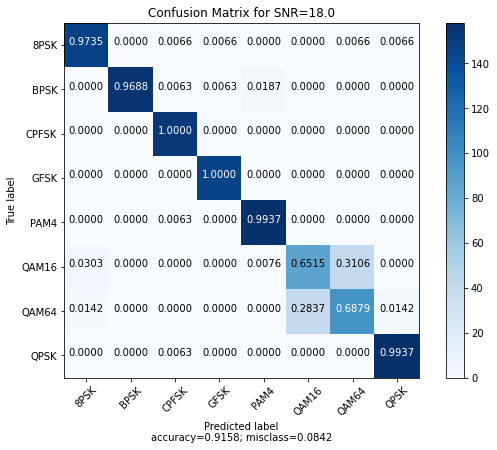

In [52]:
from sklearn.metrics import accuracy_score
accuracy_list = []
for group_id, group_df in X_test.groupby("SNR"):
    dataset = create_pytorch_dataset(group_df)
    X = dataset.tensors[0]
    y = dataset.tensors[1]
    predictions = model(X)
    cm = confmat(predictions, y)
    acc = plot_confusion_matrix(cm.numpy(), target_names=le.classes_, title=f"Confusion Matrix for SNR={group_id}")
    accuracy_list.append(acc)

In [46]:
results_df = pd.DataFrame({"SNR": np.unique(X_test['SNR'].values), "Accuracy": accuracy_list})

In [49]:
import plotly.express as px

df = px.data.gapminder().query("country=='Canada'")
fig = px.line(results_df, x="SNR", y="Accuracy", title='Classifier Performance vs SNR')
fig.show()